# 多输出模型，预测衣服种类和颜色

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

tf.__version__

'2.0.0'

## 准备数据集

In [2]:
# 数据集目录
image_dir = "dataset\\clothes"
# 数据集路径
image_path = glob.glob(image_dir + "\\*\\*")
image_num = len(image_path)
image_num

2525

In [3]:
image_path[0]

'dataset\\clothes\\black_jeans\\00000000.jpg'

In [4]:
# 数据集标签
image_label = [path.split('\\')[-2] for path in image_path]
# 颜色标签
color_label = [label.split('_')[0] for label in image_label]
# 类别标签
class_label = [label.split('_')[1] for label in image_label]
print("color_label[0]:", color_label[0])
print("class_label[0]:", class_label[0])

color_label[0]: black
class_label[0]: jeans


In [5]:
# 所有颜色
all_color = set(color_label)
all_color

{'black', 'blue', 'red'}

In [6]:
# 所有类别
all_class = set(class_label)
all_class

{'dress', 'jeans', 'shirt', 'shoes'}

In [7]:
# 颜色对应序号
color_to_index = dict((color, index) for index, color in enumerate(all_color))
# 序号对应颜色
index_to_color = dict((index, color) for index, color in enumerate(all_color))
print(color_to_index)
print(index_to_color)

{'blue': 0, 'red': 1, 'black': 2}
{0: 'blue', 1: 'red', 2: 'black'}


In [8]:
# 类别对应序号
class_to_index = dict((c, index) for index, c in enumerate(all_class))
# 序号对应类别
index_to_class = dict((index, c) for index, c in enumerate(all_class))
print(class_to_index)
print(index_to_class)

{'dress': 0, 'jeans': 1, 'shoes': 2, 'shirt': 3}
{0: 'dress', 1: 'jeans', 2: 'shoes', 3: 'shirt'}


In [9]:
# 颜色标签
color_label = [color_to_index[label] for label in color_label]
# 类别标签
class_label = [class_to_index[label] for label in class_label]
print("color_label[0]:", color_label[0])
print("class_label[0]:", class_label[0])

color_label[0]: 2
class_label[0]: 1


In [10]:
# 创建图片数据集
image_path_dataset = tf.data.Dataset.from_tensor_slices(image_path)
# 数据处理
def data_preprocess(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    # 归一化
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image
image_dataset = image_path_dataset.map(data_preprocess)
image_dataset

<MapDataset shapes: (224, 224, 3), types: tf.float32>

In [11]:
# 创建标签数据集
label_dataset = tf.data.Dataset.from_tensor_slices((color_label, class_label))
label_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.int32, tf.int32)>

In [12]:
# 合并数据和标签
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
dataset

<ZipDataset shapes: ((224, 224, 3), ((), ())), types: (tf.float32, (tf.int32, tf.int32))>

black_jeans


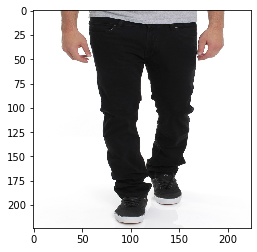

In [13]:
# 打印第一张图片
for image, label in dataset.take(1):
    plt.imshow(image)
    print(index_to_color[label[0].numpy()] + "_" + index_to_class[label[1].numpy()])

In [14]:
# 分割训练集和验证集
train_num = int(image_num * 0.8)
validation_num = image_num - train_num

dataset = dataset.shuffle(image_num)

train_dataset = dataset.take(train_num)
validation_dataset = dataset.skip(train_num)

BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(train_num).repeat().batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

print("train_dataset:", train_dataset)
print("validation_dataset:", validation_dataset)

train_dataset: <BatchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>
validation_dataset: <BatchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>


## 构建模型训练

In [15]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# 构建颜色分类器
x1 = tf.keras.layers.Dense(1024, activation='relu')(x)
color_out = tf.keras.layers.Dense(len(all_color), activation='softmax', name="color_out")(x1)
# 构建类别分类器
x2 = tf.keras.layers.Dense(1024, activation='relu')(x)
class_out = tf.keras.layers.Dense(len(all_class), activation='softmax', name="class_out")(x2)

# 构建新的模型
model = tf.keras.Model(base_model.input, [color_out, class_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss = {"color_out":"sparse_categorical_crossentropy", "class_out":"sparse_categorical_crossentropy"}, 
                  metrics = ['accuracy'])

In [18]:
model.fit(train_dataset,
          epochs = 5,
          steps_per_epoch = train_num // BATCH_SIZE,
          validation_data = validation_dataset,
          validation_steps = validation_num // BATCH_SIZE)

Train for 63 steps, validate for 15 steps
Epoch 1/5
63/63 [==============================] - 83s 1s/step - loss: 0.5197 - color_out_loss: 0.2855 - class_out_loss: 0.2341 - color_out_accuracy: 0.8800 - class_out_accuracy: 0.9172 - val_loss: 0.2226 - val_color_out_loss: 0.1583 - val_class_out_loss: 0.0643 - val_color_out_accuracy: 0.9563 - val_class_out_accuracy: 0.9792
Epoch 2/5
63/63 [==============================] - 75s 1s/step - loss: 0.0584 - color_out_loss: 0.0280 - class_out_loss: 0.0305 - color_out_accuracy: 0.9926 - class_out_accuracy: 0.9926 - val_loss: 0.1301 - val_color_out_loss: 0.1096 - val_class_out_loss: 0.0204 - val_color_out_accuracy: 0.9688 - val_class_out_accuracy: 0.9958
Epoch 3/5
63/63 [==============================] - 75s 1s/step - loss: 0.0287 - color_out_loss: 0.0186 - class_out_loss: 0.0101 - color_out_accuracy: 0.9936 - class_out_accuracy: 0.9975 - val_loss: 0.1188 - val_color_out_loss: 0.0932 - val_class_out_loss: 0.0256 - val_color_out_accuracy: 0.9792 - va